In [1]:
import numpy as np
import wandb

In [2]:
api = wandb.Api(timeout=19)

In [3]:
#regular runs 
cdan = api.run("eelismie/robust-domain-adaptation/c4g9x23v") #CDAN
mcc = api.run("eelismie/robust-domain-adaptation/2ieg23ok") #MCC
mdd = api.run("eelismie/robust-domain-adaptation/1mvvxpon") #MDD

#CFOL 
mdd_on = api.run("eelismie/robust-domain-adaptation/2uh12rpc") #MDD 
cdan_on = api.run("eelismie/robust-domain-adaptation/299m5mlc") #CDAN 
mcc_on = api.run("eelismie/robust-domain-adaptation/1jv2tvhc") #MCC 

In [6]:
print(mdd_on.summary["target test accuracy"], cdan_on.summary["target test accuracy"], mcc_on.summary["target test accuracy"])

0.5415209531784058 0.5519792437553406 0.3685064911842346


In [7]:
print(mdd.summary["target test accuracy"], cdan.summary["target test accuracy"], mcc.summary["target test accuracy"])

0.4520167410373688 0.4835476875305176 0.323801189661026


In [4]:
cfol_on = [cdan_on.history()["validation accuracy (target)"].dropna().to_numpy()] 
cfol_on += [mdd_on.history()["validation accuracy (target)"].dropna().to_numpy()]
cfol_on += [mcc_on.history()["validation accuracy (target)"].dropna().to_numpy()]

cfol_off = [cdan.history()["validation accuracy (target)"].dropna().to_numpy()] 
cfol_off += [mdd.history()["validation accuracy (target)"].dropna().to_numpy()]
cfol_off += [mcc.history()["validation accuracy (target)"].dropna().to_numpy()]

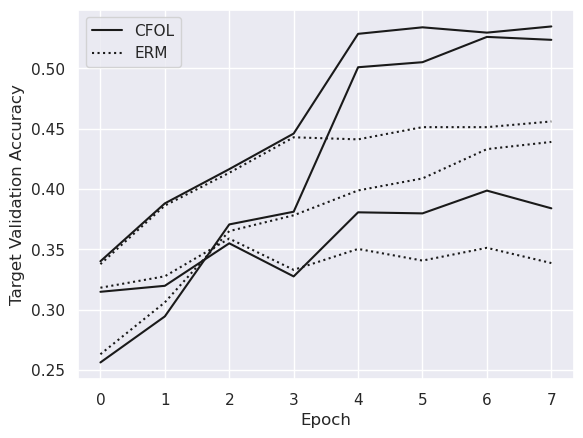

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

for i in range(3):
    y1 = cfol_on[i]
    y2 = cfol_off[i]

    #er1 = np.stack(cfol_on).std(axis=0)
    #er2 = np.stack(cfol_off).std(axis=0)

    x = [i for i in range(len(y1))]
    if (i == 0):
        plt.plot(x, y1, 'k-', label="CFOL")
        plt.plot(x, y2, 'k:', label="ERM")
    else:
        plt.plot(x, y1, 'k-')
        plt.plot(x, y2, 'k:')

plt.xlabel("Epoch")
plt.ylabel("Target Validation Accuracy")
plt.legend()
plt.savefig("CFOL_EQUIV_DOMAIN", dpi=200)
plt.show()

In [6]:
#lcvar on DomainNet 
mdd_lcvar_domain = api.run("eelismie/robust-domain-adaptation/3v3v43yh")
cdan_lcvar_domain = api.run("eelismie/robust-domain-adaptation/o4rk9jvt")
mcc_lcvar_domain = api.run("eelismie/robust-domain-adaptation/1zxqniqv")

lcvar_on = [mdd_lcvar_domain.history()["validation accuracy (target)"].dropna().to_numpy()] 
lcvar_on += [cdan_lcvar_domain.history()["validation accuracy (target)"].dropna().to_numpy()]
lcvar_on += [mcc_lcvar_domain.history()["validation accuracy (target)"].dropna().to_numpy()]

lcvar_off = [cdan.history()["validation accuracy (target)"].dropna().to_numpy()] 
lcvar_off += [mdd.history()["validation accuracy (target)"].dropna().to_numpy()]
lcvar_off += [mcc.history()["validation accuracy (target)"].dropna().to_numpy()]

In [7]:
lcvar_on = np.array(lcvar_on)
lcvar_off = np.array(lcvar_off)

In [ ]:
print(mdd_lcvar_domain.summary["target test accuracy"], cdan_lcvar_domain.summary["target test accuracy"], mcc_lcvar_domain.summary["target test accuracy"])

In [8]:
y1 = lcvar_on.mean(axis=0) 
y1

array([0.31303072, 0.36348027, 0.39307567, 0.40070347, 0.39979813,
       0.4074051 , 0.41263945, 0.4132326 , 0.41381535, 0.41169247])

In [9]:
y2 = lcvar_off.mean(axis=0)
y2

array([0.3063603 , 0.33999334, 0.37913128, 0.38465701, 0.39671787,
       0.40019355, 0.41179653, 0.41115134])

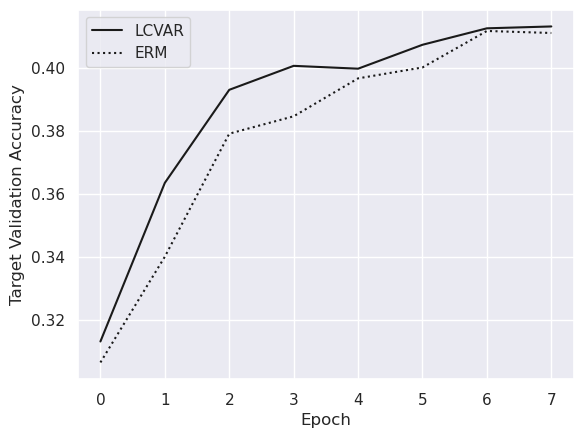

In [10]:
x = [i for i in range(len(y2))]
plt.plot(x, y1[:len(x)], 'k-', label="LCVAR")
plt.plot(x, y2[:len(x)], 'k:', label="ERM")
plt.xlabel("Epoch")
plt.ylabel("Target Validation Accuracy")
plt.legend()

In [11]:
#get the distribution of accuracies of the worst nonzero classes 
#
import numpy as np

def get_floats(dict, kw):
    valid_entries = [s for s in dict.keys() if kw in s and type(dict[s]) == float]
    return valid_entries

def extract_acc(dicts, entries):
    #extract
    result = []
    for k in entries:
        entry = []
        for d in dicts:
            entry.append(d[k])
        
        if (np.prod(entry)):
            result.append(entry)

    return result

def get_distributions(run):

    source_entries = get_floats(run.summary, "source")
    target_entries = get_floats(run.summary, "target")

    result_s = extract_acc([run.summary], source_entries)
    result_t = extract_acc([run.summary], target_entries)

    result_s.sort()
    result_t.sort()
    return np.array(result_s).flatten(), np.array(result_t)

In [12]:
#lcvar on 
sources = []
targets = []
for run in [mdd_lcvar_domain, mcc_lcvar_domain, cdan_lcvar_domain]:
    s, t = get_distributions(run)
    sources.append(s)
    targets.append(t)

#lcvar off 
sources_off = []
targets_off = []
for run in [mdd, mcc, cdan]:
    s, t = get_distributions(run)
    sources_off.append(s)
    targets_off.append(t)

In [13]:
def trim(arrays):
    min_len = min([len(a) for a in arrays])
    return [s[:min_len] for s in arrays]
#plt.plot(targets_off[2][:25], label="regular")
#plt.plot(targets[2][:25], label="lcvar")
#plt.legend()

source_off = np.stack(trim(sources_off))
source = np.stack(trim(sources))

target_off = np.stack(trim(targets_off))
target = np.stack(trim(targets))

Text(0, 0.5, 'Target Domain Accuracy')

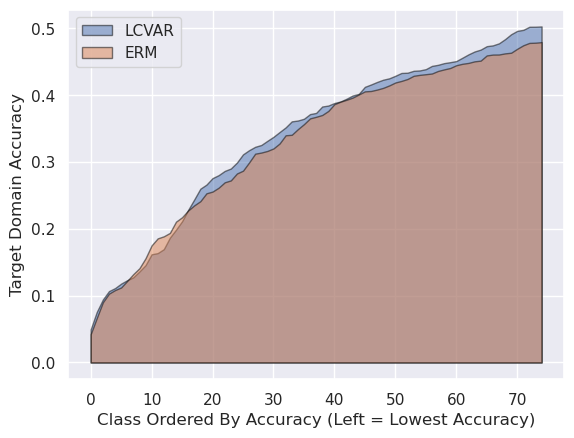

In [17]:
y1 = list(source_off.mean(axis=0).flatten())[:75]
y2 = list(source.mean(axis=0).flatten())[:75]

plt.fill_between([i for i in range(len(y1))], y2, alpha=0.5, edgecolor="black", label="LCVAR")
plt.fill_between([i for i in range(len(y2))], y1, alpha=0.5,edgecolor="black", label="ERM")
plt.legend(loc="upper left")
plt.xlabel("Class Ordered By Accuracy (Left = Lowest Accuracy)")
plt.ylabel("Source Domain Accuracy")
plt.savefig("SUMMARY_LCVAR_COMAIN_S.png", dpi=200)

Text(0, 0.5, 'Target Domain Accuracy')

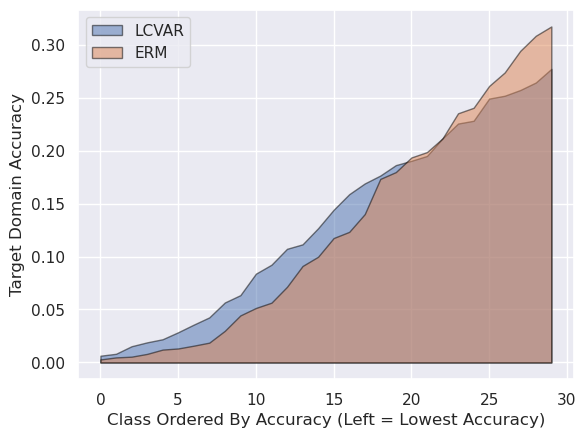

In [158]:
y1 = list(target_off.mean(axis=0).flatten())[:30]
y2 = list(target.mean(axis=0).flatten())[:30]

plt.fill_between([i for i in range(len(y1))], y2, alpha=0.5, edgecolor="black", label="LCVAR")
plt.fill_between([i for i in range(len(y2))], y1, alpha=0.5,edgecolor="black", label="ERM")
plt.legend(loc="upper left")
plt.xlabel("Class Ordered By Accuracy (Left = Lowest Accuracy)")
plt.ylabel("Target Domain Accuracy")
plt.savefig("SUMMARY_LCVAR_COMAIN_T.png", dpi=200)

In [131]:
source_off

array([0.05263158, 0.06666667, 0.07407407, 0.09090909, 0.1       ,
       0.1       , 0.10344828, 0.11111111, 0.125     , 0.13043478,
       0.13333334, 0.14285715, 0.15217391, 0.15384616, 0.18181819,
       0.18320611, 0.19444445, 0.2       , 0.20754717, 0.20833333,
       0.21428572, 0.21428572, 0.21875   , 0.22222222, 0.24137931,
       0.24561404, 0.25      , 0.27272728, 0.27586207, 0.27777779,
       0.27777779, 0.28      , 0.29032257, 0.29032257, 0.30769232,
       0.31578946, 0.33333334, 0.336     , 0.34269664, 0.34482759,
       0.35294119, 0.35338345, 0.35714287, 0.36363637, 0.37209302,
       0.37931034, 0.38028169, 0.38135594, 0.38461539, 0.3923077 ,
       0.39393941, 0.39473686, 0.40000001, 0.40000001, 0.40000001,
       0.40000001, 0.40243903, 0.40909091, 0.41025642, 0.41062802,
       0.41428572, 0.41666666, 0.41935483, 0.42105263, 0.42105263,
       0.43181819, 0.43209878, 0.43243244, 0.43529412, 0.43571427,
       0.4375    , 0.44444445, 0.44927537, 0.44999999, 0.44999

In [ ]:
plt.plot(x)

In [ ]:
# cdan_regular_domain = api.run("eelismie/robust-domain-adaptation/c4g9x23v")
# mdd_regular_domain = api.run("eelismie/robust-domain-adaptation/1mvvxpon")

# #lcvar on Visda2017 
# cdan_lcvar_visda = api.run("eelismie/robust-domain-adaptation/29269stx")
# mcc_lcvar_visda = api.run("eelismie/robust-domain-adaptation/3ej5ilky")
# mdd_lcvar_visda = api.run("eelismie/robust-domain-adaptation/1bykqq9z")


#old_run = api.run("eelismie/robust-domain-adaptation/1jv2tvhc")
#regular 
# #mdd_lcvar = api.run("eelismie/robust-domain-adaptation/3v3v43yh")
# ##eta = 0.01 
# cdan_cfol = api.run("eelismie/robust-domain-adaptation/2es7lfoj")
# mdd_cfol = api.run("eelismie/robust-domain-adaptation/1vzkmk9d")
# mcc_cfol = api.run("eelismie/robust-domain-adaptation/2f0qujxw")
# cdan_regular = api.run("eelismie/robust-domain-adaptation/c4g9x23v")
# mdd_regular = api.run("eelismie/robust-domain-adaptation/1mvvxpon")



# #batch size = 16 
# mdd_regular_run = api.run("eelismie/robust-domain-adaptation/39zz0on1")
# mdd_lcvar_run = api.run("eelismie/robust-domain-adaptation/376wjsrk")

# cdan_regular_run = api.run("eelismie/robust-domain-adaptation/p04tiwqd")
# cdan_lcvar_run = api.run("eelismie/robust-domain-adaptation/3t7dq8w7")

In [7]:
def get_floats(dict, kw):
    valid_entries = [s for s in dict.keys() if kw in s and type(dict[s]) == float]
    return valid_entries

In [8]:
import numpy as np

def extract_acc(dicts, entries):
    #extract
    result = []
    for k in entries:
        entry = []
        for d in dicts:
            entry.append(d[k])
        
        if (np.prod(entry)):
            result.append(entry)

    return result

In [42]:
source_entries = get_floats(cdan_regular_run.summary, "source")
target_entries = get_floats(cdan_regular_run.summary, "target")

#lcvar 
#res = extract_acc([mdd_regular_run.summary, mdd_lcvar_run.summary], target_entries)
#res = extract_acc([cdan_regular_run.summary, cdan_lcvar_run.summary], target_entries)

#cfol 
res = extract_acc([cdan_regular_run.summary, cdan_lcvar_run.summary], target_entries)

In [43]:
range_ = 150
reg = [i[0] for i in res]
modified = [i[1] for i in res]

#select worst :range_ classes 
reg.sort()
modified.sort()


reg = reg[:range_]
modified = modified[:range_]


Text(0.5, 1.0, 'Class Accuracies for CDAN on DomainNet')

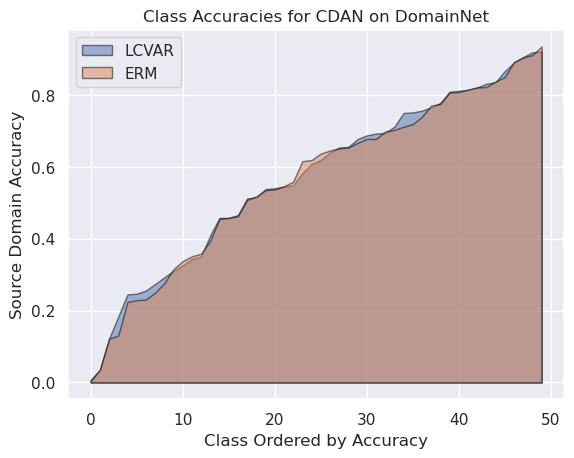

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()  # <-- This actually changes the look of plots.
#plt.plot([reg, modified], color=['r','b'], alpha=0.5, label=["ERM", "LCVAR"])
plt.fill_between([i for i in range(len(reg))], modified, alpha=0.5, edgecolor="black", label="LCVAR")
plt.fill_between([i for i in range(len(reg))], reg, alpha=0.5,edgecolor="black", label="ERM")
plt.legend(loc="upper left")
plt.xlabel("Class Ordered by Accuracy")
plt.ylabel("Source Domain Accuracy")
plt.title("Class Accuracies for CDAN on DomainNet")
#plt.savefig("MDD_LCVAR_SOURCE_DOMAIN", dpi=200)


In [4]:
#regular runs 
api.run("eelismie/robust-domain-adaptation/c4g9x23v") #CDAN
api.run("eelismie/robust-domain-adaptation/2ieg23ok") #MCC
api.run("eelismie/robust-domain-adaptation/1mvvxpon") #MDD

#CFOL 
api.run("eelismie/robust-domain-adaptation/2uh12rpc") #MDD 
api.run("eelismie/robust-domain-adaptation/299m5mlc") #CDAN 
api.run("eelismie/robust-domain-adaptation/1jv2tvhc") #MCC 

<Run eelismie/robust-domain-adaptation/1mvvxpon (finished)>